In [1]:
#Import helper functions
import numpy as np
import matplotlib.pyplot as plt

# Used parameters

The [Bloqade home page](https://queracomputing.github.io/Bloqade.jl/dev/) describes the default parameters or conventions which are used in the simulator. They are copied here for convinience in order to show more clearly if those values are the same required by the [paper](https://arxiv.org/pdf/2111.10956.pdf) when trying to replicate their results

## Bloqade defaults:
Conventions:
- Used atoms: ∣r⟩=∣70S1/2⟩∣r⟩=∣70S1/2​⟩ of the Rb-87 atoms;
- Sometimes, in the analog mode the states ∣g⟩ and ∣r⟩ are also refered as ∣0⟩ and ∣1⟩

Parameters:
- $ C_6 = 862690 \times 2π MHz μm^6 $ 

## Paper set-up
Params:
- _[cited from IV. - page 6]_ In these experiments, an off-resonance intermediate state, $|6P_{3/2}, F = 3, M_F = −3〉$, is used to couple $|g〉 = |5S_{1/2}, F = 2, m_F = −2〉$ and $|r〉 = |70S_{1/2}, m_J = −1/2, m_I = −3/2〉$ of Rubidium-87 atoms through a two-photon transition
- _[cited from Appendix D]_ In this experimental platform, a two-photon transition couples $|g〉 = |5S_{1/2}〉$ and $|r〉 = |50S_{1/2}〉$ via an off-resonance state $|6P_{3/2}〉$
    - $ \Omega = 4.2 MHz $
    - $ C_6 = 862.9 GHz(μm)^6 $
    - We used the `PairInteraction` python package from [58] to determine that a pair of $|r〉 = |70S_{1/2}〉$ and $|r′〉 = |73S_{1/2}〉$ has a similar interaction strength of $C_6^{rr′} = −836.6 GHz(μm)^6 ≈ −C_6$. We used this interaction to model the inhibitory and excitatory neurons in Sec. V A $(V_{nQ ,nQ} = V , V_{nQ ,n′Q} = −V )$. We denote $V = C_6/a_0^6$ where $a_0$ is tuned to give us different nearest neighbor interaction strengths.

`Multitasking` method summary:
- Relies on approximating equation (13): $L^+ = √γ|g〉 (α〈r| + β〈g|) $
- This task uses a 1D open chain of atoms separated by a **distance $a_0$** with the *inhibitory neurons being at opposite ends of the chain* and in the bulk with maximum spacing from each other. 
- The *input neurons* are chosen to be *the two at one end of the chain*, while the *output neuron* is chosen to be *at the opposite end of the chain*. This choice was made to ensure that the input neurons interact with the whole chain before readout.
- The inputs are uniformly sampled from ${0, 2\pi} MHz$ with added Gaussian noise $\sigma_{in} = 0.1$, and all $\Delta t$ sampled from a Gaussian with average $〈∆t〉 ∈ [0, 5]$ (μs) and standard deviation $\sigma_{in}$.
- For each size of the network and number of inhibitory neurons, We choose $a_0$ such that the separation between inhibitory neurons $d_{max}$ results in $V /d^2_{max} = 10^{−2}$. For example, for the case of 4 neurons and two inhibitory neurons on either end, note that one needs $V /3^6 = 10^{−2}$, which amounts to choosing $V = 7.2$ MHz. Note that this value of V is of the order of **magnitude of $\Omega = 4.2$ MHz** and so the reservoir, in this case, is well into the non-classical regime.


In [2]:
#Build an atoms arrangement
from braket.ahs.atom_arrangement import AtomArrangement

def chain_lattice(n_atoms,lattice_spacing):
    register = AtomArrangement()
    
    for i in range(n_atoms):
        register.add([0.0, i*lattice_spacing])

    return register

In [3]:
from braket.aws import AwsDevice 
from pprint import pprint as pp

# defining qpu object
qpu = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")

# capabilities stored as attribute of AwsDevice.
capabilities = qpu.properties.paradigm

# print out lattice
pp(capabilities.lattice.dict())

{'area': {'height': Decimal('0.000076'), 'width': Decimal('0.000075')},
 'geometry': {'numberSitesMax': 256,
              'positionResolution': Decimal('1E-7'),
              'spacingRadialMin': Decimal('0.000004'),
              'spacingVerticalMin': Decimal('0.000004')}}


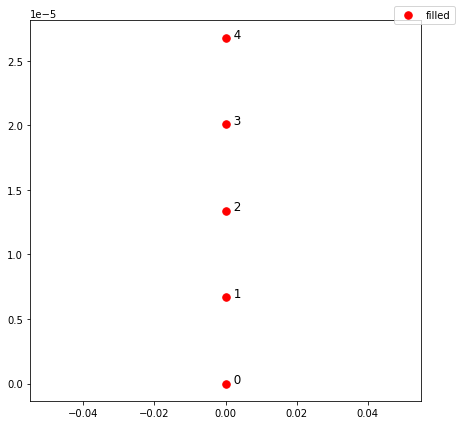

In [4]:
from quera_ahs_utils.plotting import show_register

lattice_spacing = 6.7e-6
# Defined above
far_register = chain_lattice(5,lattice_spacing)
show_register(far_register)

In [5]:
pp(capabilities.rydberg.rydbergGlobal.dict())

{'detuningRange': (Decimal('-125000000.0'), Decimal('125000000.0')),
 'detuningResolution': Decimal('0.2'),
 'detuningSlewRateMax': Decimal('2500000000000000.0'),
 'phaseRange': (Decimal('-99.0'), Decimal('99.0')),
 'phaseResolution': Decimal('5E-7'),
 'rabiFrequencyRange': (Decimal('0.0'), Decimal('15800000.0')),
 'rabiFrequencyResolution': Decimal('400.0'),
 'rabiFrequencySlewRateMax': Decimal('250000000000000.0'),
 'timeDeltaMin': Decimal('5E-8'),
 'timeMax': Decimal('0.000004'),
 'timeMin': Decimal('0.0'),
 'timeResolution': Decimal('1E-9')}


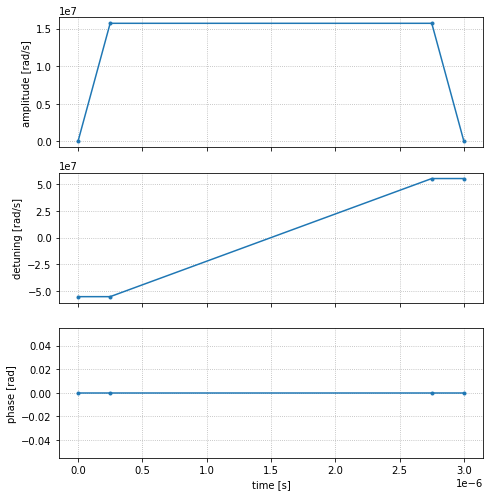

In [6]:
from quera_ahs_utils.plotting import show_global_drive
from quera_ahs_utils.drive import get_drive

time_points = [0, 2.5e-7, 2.75e-6, 3e-6]
amplitude_min = 0
amplitude_max = 1.57e7  # rad / s

delta_min = -5.5e7  # rad / s
delta_max = 5.5e7  # rad / s

amplitude_values = [amplitude_min, amplitude_max, amplitude_max, amplitude_min]  # piece-wise linear
detuning_values = [delta_min, delta_min, delta_max, delta_max]  # piece-wise linear
phase_values = [0, 0, 0, 0]  # piece-wise constant


drive = get_drive(time_points, amplitude_values, detuning_values, phase_values)
show_global_drive(drive)

In [7]:
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation

# define program
far_ahs_program = AnalogHamiltonianSimulation(
    register=far_register, 
    hamiltonian=drive
)

In [8]:
from braket.devices import LocalSimulator

# running tasks on your computer with a local simulator
qpu_sim = LocalSimulator("braket_ahs")

In [9]:
# function to save results to a file
def save_result(filename,result):

    qpu_results = []
    for measurement in result.measurements: # loop over all shots (measurements)
        qpu_results.append(measurement.post_sequence)

    qpu_results = np.asarray(qpu_results)
    np.savetxt(filename,qpu_results)
    
    
# run program
result = qpu_sim.run(far_ahs_program, shots=1000).result()
save_result("3x3_simulator.txt",result)

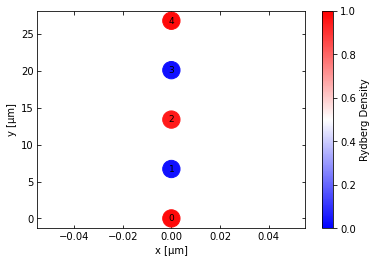

In [10]:
import matplotlib.pyplot as plt
from quera_ahs_utils.plotting import plot_avg_density

# load and analyze results
qpu_results = np.loadtxt("3x3_simulator.txt")

# calculating average rydberg density from shot data
# 0 => rydberg
# 1 => ground state
rydberg_density = np.mean(1-qpu_results,axis=0)

f,ax = plt.subplots(1,1)
plot_avg_density(
    rydberg_density,
    far_register,
    custom_axes = ax
)
plt.show()